In [1]:
import numpy as np
import scipy.stats as spst
from tqdm import tqdm
from sif.models.sigmoid import sigmoid
from sif.kernels import BrownianMotionKernel
from sif.samplers import multivariate_normal_sampler

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In this notebook I will apply Girsanov's Theorem to Langevin dynamics for a Bayesian logistic regression problem. Recall that Girsanov's Theorem says that if $W_t$ is a Brownian motion and $\Theta_t$ is a stochastic process adapted to that Brownian motion, then we may define the Radon-Rikodym derivative process
\begin{align}
Z(t) &= \exp\left(-\int_0^t \Theta_s dW_s - \frac{1}{2} \int_0^t \Theta_s^2 ds\right) \\
Z &\equiv Z(T)
\end{align}
and under the probability measure $\tilde{\mathbb{P}}(A)= \int_A Z(\omega) d\mathbb{P}(\omega)$ the process
\begin{align}
\tilde{W}_t &= W_t + \int_0^t \Theta_s ds
\end{align}
is a Brownian motion.

Consider the Langevin equation for sampling from a distribution $p(x)\propto \exp\left(-V(x)\right)$:
\begin{align}
dX_t = -\frac{1}{2}\nabla V(X_t) dt + dW_t
\end{align}
Integrating from differential notation to integral notation this says,
\begin{align}
X_t - X_0 = W_t + \int_0^t \left(-\frac{1}{2}\nabla V(X_s)\right) ds
\end{align}
which, when $X_0\equiv 0$ resembles the Girsanov Brownian motion with adapted process $\Theta_t \equiv -\frac{1}{2}\nabla V(X_t)$.

First I'll generate some random data from a logistic regression model using a two-dimensional known coefficient vector. I'll also define a function for computing the gradient of log-posterior.

In [3]:
n = 100
loss_div = 1
beta_star = np.array([2, -1])
X = np.random.normal(scale=2, size=(n, len(beta_star)))
y = np.random.binomial(1, sigmoid(X.dot(beta_star)))

In [4]:
def grad_V(beta, lambda_reg=1.):
    y_tile = np.tile(np.atleast_2d(y).T, beta.shape[0])
    ll_grad = -X.T.dot(y_tile - sigmoid(X.dot(beta.T)))
    ll_grad = ll_grad.T
    reg_grad = lambda_reg * beta
    return (ll_grad + reg_grad) / loss_div

I set the learning rate to some small number. I'll also choose a number of trials to perform that is inversely proportional to the selected learning rate. This has the effect of running the stochastic dynamics forward in time until one unit of time has elapsed.

In [5]:
dt = 1e-3 / n
time_units = 3/n
n_iter = int(time_units * 1/dt)
n_trials = 5000

Create arrays that contain the Brownian differential and the Brownian motion. Initialize arrays that will contain the gradient process and the Langevin dynamics process.

In [6]:
dB = np.random.normal(scale=np.sqrt(dt / loss_div), size=(n_trials, n_iter + 1, X.shape[1]))
B = np.cumsum(dB[:, :-1, :], axis=1)
Theta = np.zeros(B.shape)
Beta = np.zeros(B.shape)
# Beta[:, 0, :] = beta_star
beta_init = np.array([ 1.55452502, -0.78723773])
Beta[:, 0, :] = beta_init

In [7]:
for i in tqdm(range(1, n_iter)):
    beta = Beta[:, i-1]
    Theta[:, i] = -0.5*grad_V(beta)
    Beta[:, i] = beta + Theta[:, i]*dt + dB[:, i]#/np.sqrt(loss_div)

100%|██████████| 2998/2998 [00:47<00:00, 62.98it/s]


In [8]:
Beta.mean(axis=0)

array([[ 1.55452502, -0.78723773],
       [ 1.55456543, -0.78719167],
       [ 1.55459717, -0.78716402],
       ...,
       [ 1.53052865, -0.74073385],
       [ 1.53053893, -0.74070526],
       [ 1.53055269, -0.74070368]])

Compute the Radon-Nikodym derivative process.

In [52]:
alpha = -np.cumsum((Theta*dB[:, :-1, :]).sum(axis=2), axis=1)
# alpha = -np.cumsum((Theta*np.random.normal(scale=np.sqrt(dt), size=Theta.shape)).sum(axis=2), axis=1)
beta = -0.5 * np.cumsum((Theta**2).sum(axis=2) * dt, axis=1)
delta = np.cumsum(Theta*dt, axis=1)
B_tilde = B + delta - dB[:, [0], :]

In [53]:
Z = np.exp(alpha + beta)

In [54]:
print(Z.mean(axis=0))

[1.         0.99998973 1.00000492 ... 1.0034745  1.00330653 1.00328201]


In [55]:
print(B_tilde + beta_init - Beta)

[[[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -1.11022302e-16]
  ...
  [ 2.66453526e-15  3.33066907e-15]
  [ 2.88657986e-15  3.44169138e-15]
  [ 2.88657986e-15  3.44169138e-15]]

 [[ 0.00000000e+00  0.00000000e+00]
  [-2.22044605e-16  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  ...
  [-4.66293670e-15  4.44089210e-16]
  [-4.66293670e-15  5.55111512e-16]
  [-4.44089210e-15  5.55111512e-16]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 2.22044605e-16  0.00000000e+00]
  ...
  [-2.88657986e-15  2.66453526e-15]
  [-2.88657986e-15  2.66453526e-15]
  [-2.88657986e-15  2.77555756e-15]]

 ...

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  ...
  [-4.88498131e-15 -2.44249065e-15]
  [-5.10702591e-15 -2.55351296e-15]
  [-4.88498131e-15 -2.55351296e-15]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.0000

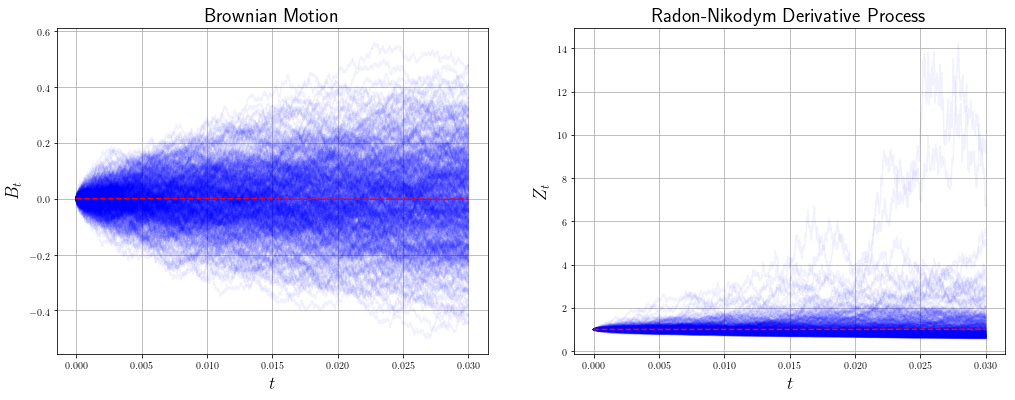

In [56]:
plt.figure(figsize=(17, 6))
T = np.linspace(0, time_units, n_iter)

plt.subplot(1, 2, 1)
for i in range(min(500, n_trials)):
    plt.plot(T, B[i, :, 0], "b-", alpha=0.05)
plt.plot(T, B[:, :, 0].mean(axis=0), "r--")
plt.grid()
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$B_t$", fontsize=18)
plt.title("Brownian Motion", fontsize=20)

plt.subplot(1, 2, 2)
for i in range(min(500, n_trials)):
    plt.plot(T, Z[i], "b-", alpha=0.05)
plt.plot(T, Z.mean(axis=0), "r--")
plt.grid()
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$Z_t$", fontsize=18)
plt.title("Radon-Nikodym Derivative Process", fontsize=20)

plt.show()

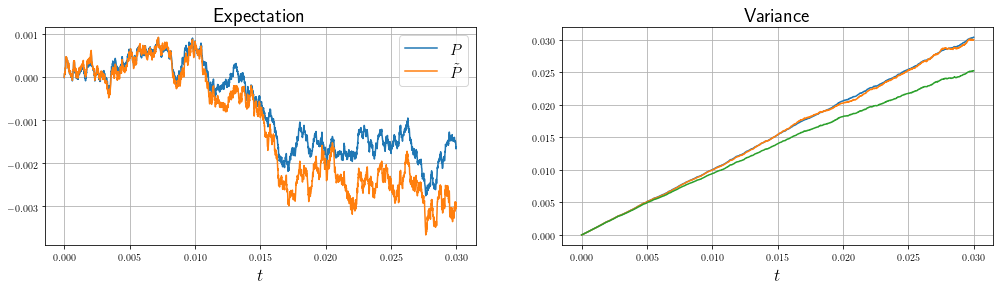

In [57]:
plt.figure(figsize=(17, 4))

plt.subplot(1, 2, 1)
plt.plot(T.ravel(), B[:, :, 0].mean(axis=0), label="$P$")
plt.plot(T.ravel(), (B_tilde[:, :, 0] * Z).mean(axis=0), label="$\\tilde{P}$")
plt.grid()
plt.gca().set_title("Expectation", fontsize=20)
plt.legend(fontsize=16)
plt.xlabel("$t$", fontsize=18)

plt.subplot(1, 2, 2)
plt.plot(T.ravel(), B[:, :, 0].var(axis=0))
plt.plot(T.ravel(), ((B_tilde[:, :, 0]**2) * Z).mean(axis=0) - (B_tilde[:, :, 0] * Z).mean(axis=0)**2)
plt.plot(T.ravel(), Beta[:, :, 0].var(axis=0))
plt.grid()
plt.xlabel("$t$", fontsize=18)
plt.gca().set_title("Variance", fontsize=20)

plt.show()

In [58]:
W_tilde = B_tilde[:, :, 0]
R = np.outer(np.mean(W_tilde * Z, axis=0), np.mean(W_tilde * Z, axis=0))
S = W_tilde.T.dot(W_tilde * Z) / n_trials
i_lower = np.tril_indices(R.shape[0], -1)
S[i_lower] = S.T[i_lower]
K_tilde = S - R

In [59]:
kernel = BrownianMotionKernel()
C = kernel.cov(np.atleast_2d(T).T)
K = np.cov(Beta[:, :, 0].T)

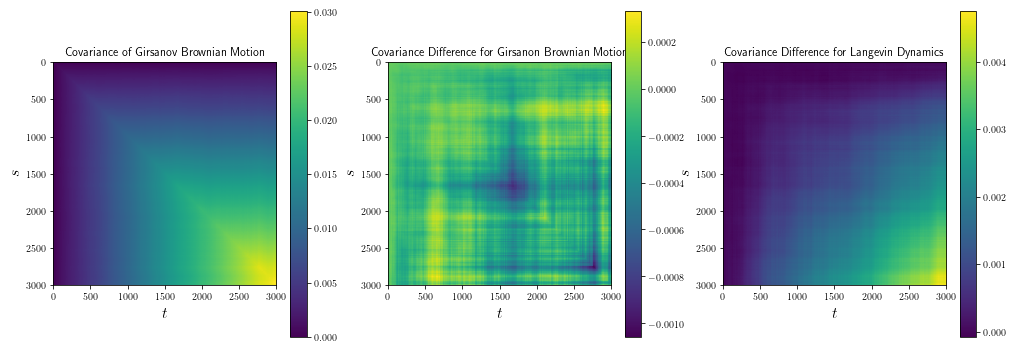

In [60]:
plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
plt.imshow(K_tilde)
plt.xlabel("$t$", fontsize=16)
plt.ylabel("$s$", fontsize=16)
plt.title("Covariance of Girsanov Brownian Motion")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(C - K_tilde)
plt.xlabel("$t$", fontsize=16)
plt.ylabel("$s$", fontsize=16)
plt.title("Covariance Difference for Girsanon Brownian Motion")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(C - K)
plt.xlabel("$t$", fontsize=16)
plt.ylabel("$s$", fontsize=16)
plt.title("Covariance Difference for Langevin Dynamics")
plt.colorbar()
plt.show()